The loading of the dataset


In [4]:
import pandas as pd
import json
import xml.etree.ElementTree as ET
import os

# Define your file paths based on the folder structure in your image
paths = {
    # UPDATED: Pointing to the CSV file instead of XLSX
    "anilist_csv": os.path.join("Datasets", "Holy_Dataset", "anilist_anime_data_complete.csv"),
    "mal_csv": os.path.join("Datasets", "anime-dataset-2023.csv"),
    "offline_db_json": os.path.join("Datasets", "anime-offline-database.json"),
    "user_xml": os.path.join("Datasets", "anilist.xml")
}

def load_all_data():
    print("--- Loading Datasets ---")

    # 1. Load the AniList CSV File (Holy_Dataset)
    try:
        print(f"Loading AniList data from {paths['anilist_csv']}...")
        # UPDATED: Using read_csv instead of read_excel
        df_anilist = pd.read_csv(paths['anilist_csv'])
        print(f"✅ Loaded AniList Data: {df_anilist.shape[0]} rows")
    except Exception as e:
        print(f"❌ Error loading AniList CSV: {e}")
        df_anilist = pd.DataFrame()

    # 2. Load the MAL CSV File
    try:
        print(f"Loading MAL data from {paths['mal_csv']}...")
        df_mal = pd.read_csv(paths['mal_csv'])
        print(f"✅ Loaded MAL Data: {df_mal.shape[0]} rows")
    except Exception as e:
        print(f"❌ Error loading MAL CSV: {e}")
        df_mal = pd.DataFrame()

    # 3. Load the Anime Offline Database (JSON)
    try:
        print(f"Loading Offline Database from {paths['offline_db_json']}...")
        with open(paths['offline_db_json'], 'r', encoding='utf-8') as f:
            data_json = json.load(f)
        
        if 'data' in data_json:
            df_offline = pd.DataFrame(data_json['data'])
        else:
            df_offline = pd.DataFrame(data_json)
            
        print(f"✅ Loaded Offline DB: {df_offline.shape[0]} rows")
    except Exception as e:
        print(f"❌ Error loading JSON: {e}")
        df_offline = pd.DataFrame()

    # 4. Load Personal User XML Data (anilist.xml)
    try:
        print(f"Loading User XML from {paths['user_xml']}...")
        tree = ET.parse(paths['user_xml'])
        root = tree.getroot()

        xml_data = []
        for anime in root.findall('anime'):
            entry = {}
            for child in anime:
                entry[child.tag] = child.text
            xml_data.append(entry)

        df_user = pd.DataFrame(xml_data)
        print(f"✅ Loaded User Data: {df_user.shape[0]} entries")
    except Exception as e:
        print(f"❌ Error loading User XML: {e}")
        df_user = pd.DataFrame()

    return df_anilist, df_mal, df_offline, df_user

if __name__ == "__main__":
    # Run the loader
    anilist_df, mal_df, offline_df, user_df = load_all_data()

    # Preview the data
    print("\n--- Previews ---")
    if not anilist_df.empty:
        print("\nAniList Sample:")
        # Adjusting column names to likely CSV headers (may vary slightly from Excel)
        cols_to_show = [col for col in ['title_english', 'averageScore', 'popularity'] if col in anilist_df.columns]
        print(anilist_df[cols_to_show].head(3))
    
    if not user_df.empty:
        print("\nUser List Sample:")
        print(user_df[['series_title', 'my_score', 'my_status']].head(3))

--- Loading Datasets ---
Loading AniList data from Datasets\Holy_Dataset\anilist_anime_data_complete.csv...
✅ Loaded AniList Data: 20099 rows
Loading MAL data from Datasets\anime-dataset-2023.csv...
✅ Loaded MAL Data: 24905 rows
Loading Offline Database from Datasets\anime-offline-database.json...
✅ Loaded Offline DB: 39277 rows
Loading User XML from Datasets\anilist.xml...
✅ Loaded User Data: 328 entries

--- Previews ---

AniList Sample:
                title_english  averageScore  popularity
0  Tales of the Street Corner          62.0        2046
1                         NaN          57.0         409
2        Kimba the White Lion          61.0        2449

User List Sample:
     series_title my_score  my_status
0  Bungaku Shoujo        6  Completed
1  86: Eighty Six        7  Completed
2       A-Channel        4    Dropped


In [5]:
import xml.etree.ElementTree as ET
import pandas as pd
import os

def convert_mal_xml_to_csv(xml_file_path, output_csv_path):
    """
    Parses MyAnimeList XML export and saves it as a CSV.
    """
    print(f"Parsing {xml_file_path}...")
    
    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        
        anime_list = []
        
        # Iterate through each <anime> tag
        for anime in root.findall('anime'):
            # Extract text safely (returns None if tag is missing)
            entry = {
                'mal_id': anime.findtext('series_animedb_id'),
                'title': anime.findtext('series_title'),
                'type': anime.findtext('series_type'),
                'episodes': anime.findtext('series_episodes'),
                'my_id': anime.findtext('my_id'),
                'watched_episodes': anime.findtext('my_watched_episodes'),
                'start_date': anime.findtext('my_start_date'),
                'finish_date': anime.findtext('my_finish_date'),
                'score': anime.findtext('my_score'), # User's score
                'status': anime.findtext('my_status'), # e.g., Completed, Dropped
                'tags': anime.findtext('my_tags'),
                'comments': anime.findtext('my_comments')
            }
            anime_list.append(entry)
            
        # Create DataFrame
        df = pd.DataFrame(anime_list)
        
        # Clean up data types
        numeric_cols = ['mal_id', 'episodes', 'watched_episodes', 'score']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
            
        # Save to CSV
        df.to_csv(output_csv_path, index=False)
        print(f"✅ Successfully converted {len(df)} entries to {output_csv_path}")
        return df

    except Exception as e:
        print(f"❌ Error converting XML: {e}")
        return None

if __name__ == "__main__":
    # Update this path to where your actual XML file is located
    xml_path = os.path.join("Datasets", "anilist.xml")
    csv_out = "user_animelist_normalized.csv"
    
    # Create a dummy XML file for demonstration if the file doesn't exist
    if not os.path.exists(xml_path):
        print(f"Note: {xml_path} not found. Creating a temporary test file based on your snippet.")
        dummy_xml = """<?xml version="1.0" encoding="UTF-8" ?>
        <myanimelist>
            <myinfo><username>Nakattakan</username></myinfo>
            <anime>
                <series_animedb_id>6408</series_animedb_id>
                <series_title><![CDATA[Bungaku Shoujo]]></series_title>
                <series_type>MOVIE</series_type>
                <series_episodes>1</series_episodes>
                <my_score>6</my_score>
                <my_status>Completed</my_status>
            </anime>
            <anime>
                <series_animedb_id>41457</series_animedb_id>
                <series_title><![CDATA[86: Eighty Six]]></series_title>
                <series_type>TV</series_type>
                <series_episodes>11</series_episodes>
                <my_score>7</my_score>
                <my_status>Completed</my_status>
            </anime>
        </myanimelist>
        """
        with open("test_anilist.xml", "w") as f:
            f.write(dummy_xml)
        xml_path = "test_anilist.xml"

    convert_mal_xml_to_csv(xml_path, csv_out)

Parsing Datasets\anilist.xml...
✅ Successfully converted 328 entries to user_animelist_normalized.csv


--- Analyzing Popularity vs Rating ---

📊 Correlation between Rating and Popularity: 0.4235
>> Moderate positive relationship.

📈 Average Popularity by Rating Tier:
             mean  median  count
score_bin                       
<4           1535     402    198
4-5          2244     511    895
5-6          6001    1407   2020
6-7         18998    6038   3300
7-8         54154   26467   1958
8-9        158342  101306    398
9-10       157386  113200      4

🎨 Generating Plots...


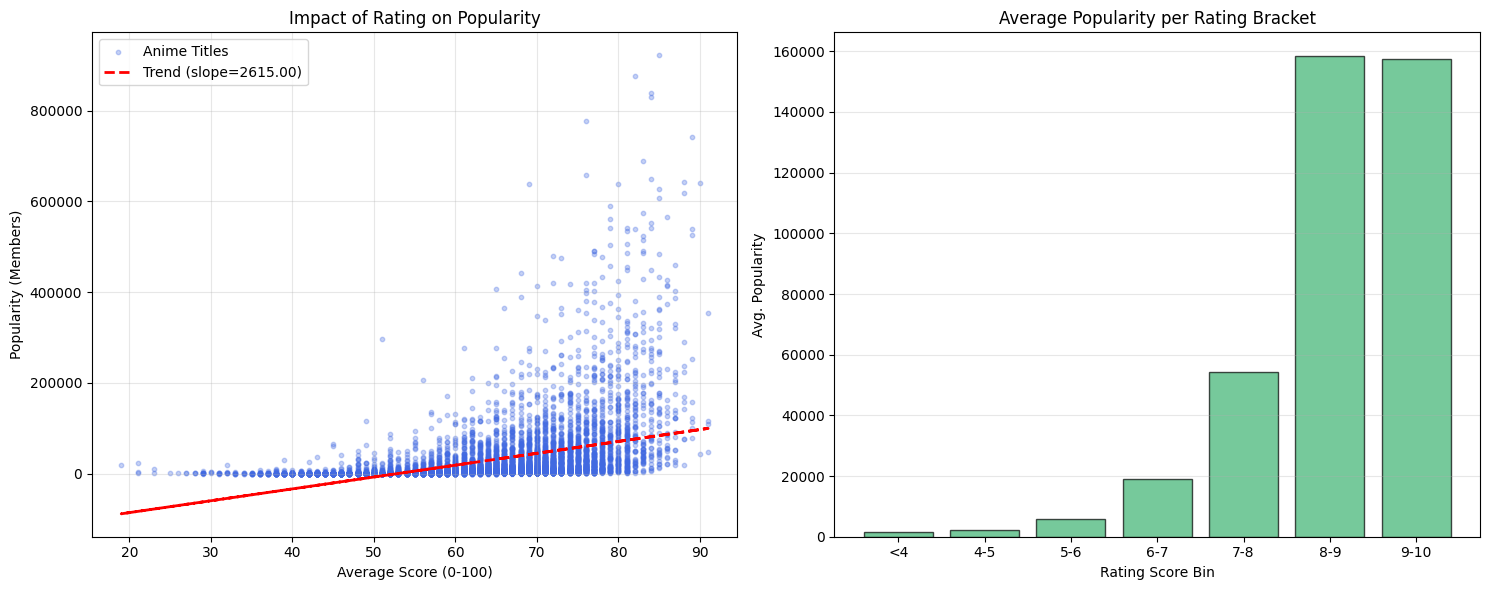


💎 Hidden Gems (High Rating > 85, Low Popularity < Median):


In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# File paths (matching your load_datasets.py structure)
csv_path = os.path.join("Datasets", "Holy_Dataset", "anilist_anime_data_complete.csv")

def analyze_popularity_vs_rating():
    print("--- Analyzing Popularity vs Rating ---")
    
    if not os.path.exists(csv_path):
        print(f"❌ File not found: {csv_path}")
        return

    # Load Data
    # Using 'averageScore' (0-100) and 'popularity' (member count) from AniList dataset
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return

    # Filter relevant columns and drop rows with missing values
    # AniList uses 'averageScore' (0-100)
    if 'averageScore' in df.columns and 'popularity' in df.columns:
        analysis_df = df[['title_english', 'averageScore', 'popularity']].dropna()
    else:
        print("Required columns (averageScore, popularity) not found.")
        print(f"Available columns: {df.columns.tolist()}")
        return

    # 1. Correlation Coefficient
    # A value closer to 1.0 means strong positive correlation (higher rating = higher popularity)
    correlation = analysis_df['averageScore'].corr(analysis_df['popularity'])
    print(f"\n📊 Correlation between Rating and Popularity: {correlation:.4f}")
    
    if correlation > 0.5:
        print(">> Strong positive relationship: Better rated shows are generally more popular.")
    elif correlation > 0.3:
        print(">> Moderate positive relationship.")
    else:
        print(">> Weak relationship: High ratings don't guarantee popularity.")

    # 2. Grouped Analysis (Binning)
    # Convert 0-100 score to 0-10 bins for easier reading
    analysis_df['score_bin'] = pd.cut(analysis_df['averageScore'], 
                                      bins=[0, 40, 50, 60, 70, 80, 90, 100], 
                                      labels=['<4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10'])

    grouped = analysis_df.groupby('score_bin', observed=False)['popularity'].agg(['mean', 'median', 'count'])
    
    print("\n📈 Average Popularity by Rating Tier:")
    print(grouped.round(0).astype(int))

    # --- PLOTTING SECTION ---
    print("\n🎨 Generating Plots...")
    
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Scatter Plot with Numpy Trend Line
    x = analysis_df['averageScore']
    y = analysis_df['popularity']
    
    # Scatter points (alpha for transparency helps see density)
    ax1.scatter(x, y, alpha=0.3, s=10, c='royalblue', label='Anime Titles')
    
    # Numpy: Calculate Trend Line (1st degree polynomial = linear regression)
    if len(x) > 1:
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        # Plot the trend line
        ax1.plot(x, p(x), "r--", linewidth=2, label=f'Trend (slope={z[0]:.2f})')
    
    ax1.set_title('Impact of Rating on Popularity')
    ax1.set_xlabel('Average Score (0-100)')
    ax1.set_ylabel('Popularity (Members)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Bar Chart of Average Popularity by Tier
    # Using the 'mean' column from our grouped dataframe
    categories = grouped.index.astype(str)
    values = grouped['mean']
    
    ax2.bar(categories, values, color='mediumseagreen', alpha=0.7, edgecolor='black')
    ax2.set_title('Average Popularity per Rating Bracket')
    ax2.set_xlabel('Rating Score Bin')
    ax2.set_ylabel('Avg. Popularity')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # 3. Top Outliers (High Rating, Low Popularity vs High Popularity, Low Rating)
    print("\n💎 Hidden Gems (High Rating > 85, Low Popularity < Median):")
    median_pop = analysis_df['popularity'].median()
    gems = analysis_df[
        (analysis_df['averageScore'] > 85) & 
        (analysis_df['popularity'] < median_pop)
    ].sort_values('averageScore', ascending=False).head(5)
    
    for _, row in gems.iterrows():
        print(f"- {row['title_english']}: Score {row['averageScore']}, Pop {row['popularity']}")

if __name__ == "__main__":
    analyze_popularity_vs_rating()

--- 🕵️ Analyzing Your Taste vs. The World ---
✅ Analyzed 225 shared titles.


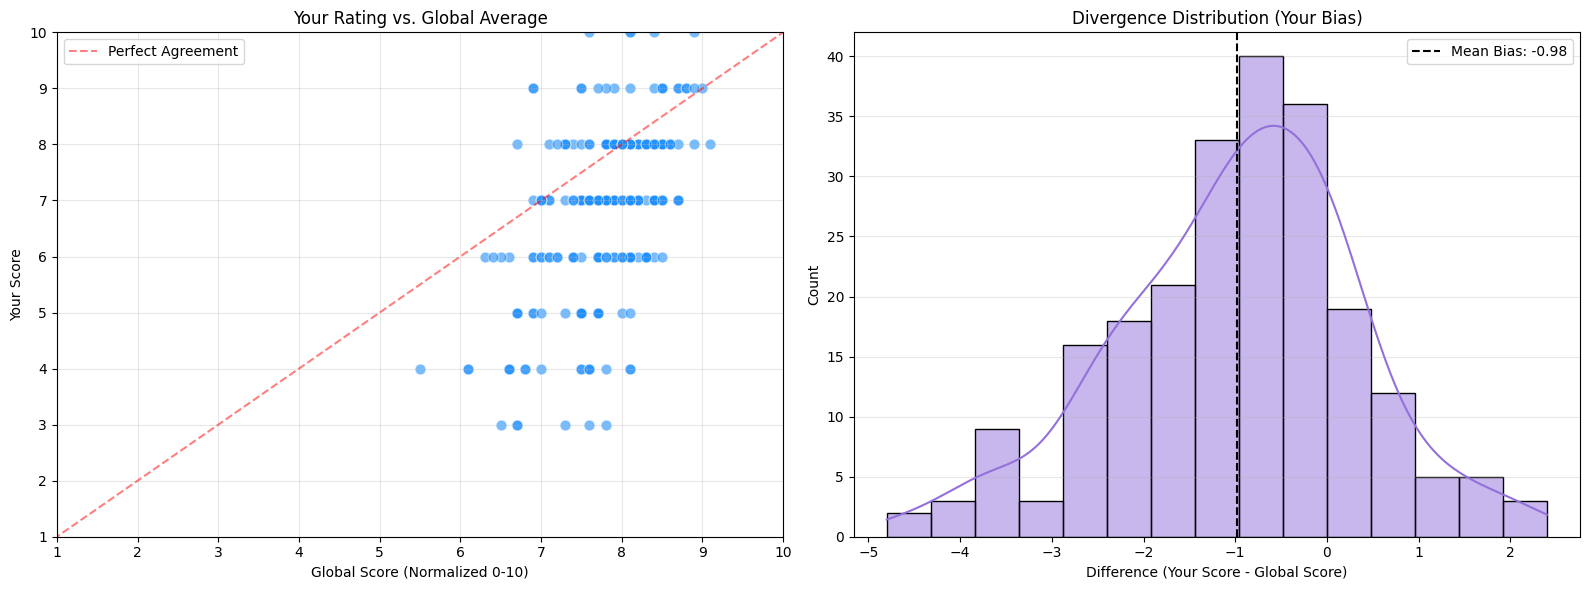


🧐 Your Most Controversial Opinions:

📉 Hater Takes (You rated much lower):
  - The Pet Girl of Sakurasou: You 3 vs Global 7.8 (Diff: -4.8)
  - The 100 Girlfriends Who Really, Really, Really, Really, REALLY Love You: You 3 vs Global 7.6 (Diff: -4.6)
  - Sword Art Online the Movie: Ordinal Scale: You 3 vs Global 7.3 (Diff: -4.3)

📈 Fanboy Takes (You rated much higher):
  - Kanon (2006): You 10 vs Global 7.6 (Diff: +2.4)
  - nan: You 9 vs Global 6.9 (Diff: +2.1)
  - nan: You 9 vs Global 6.9 (Diff: +2.1)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
GLOBAL_CSV_PATH = os.path.join("Datasets", "Holy_Dataset", "anilist_anime_data_complete.csv")
# Assuming you ran the xml_to_csv.py script earlier
USER_CSV_PATH = "user_animelist_normalized.csv" 

def analyze_user_vs_global():
    print("--- 🕵️ Analyzing Your Taste vs. The World ---")
    
    # 1. Load Datasets
    if not os.path.exists(GLOBAL_CSV_PATH) or not os.path.exists(USER_CSV_PATH):
        print(f"❌ Missing files.\nGlobal: {os.path.exists(GLOBAL_CSV_PATH)}\nUser: {os.path.exists(USER_CSV_PATH)}")
        print("Please run 'xml_to_csv.py' first to generate your user CSV.")
        return

    df_global = pd.read_csv(GLOBAL_CSV_PATH)
    df_user = pd.read_csv(USER_CSV_PATH)

    # 2. Prepare for Merge
    # Global dataset often has 'idMal' for MyAnimeList ID mapping
    if 'idMal' not in df_global.columns:
        print("❌ Global dataset missing 'idMal' column for mapping.")
        return
    
    # User dataset from XML usually has 'mal_id'
    if 'mal_id' not in df_user.columns:
        print("❌ User dataset missing 'mal_id' column.")
        return

    # Filter Global to only relevant columns to save memory
    df_global_clean = df_global[['idMal', 'title_english', 'averageScore', 'popularity']].dropna(subset=['idMal'])
    
    # 3. Merge
    # Inner join: We only care about anime you have actually rated
    merged = pd.merge(
        df_user, 
        df_global_clean, 
        left_on='mal_id', 
        right_on='idMal', 
        how='inner'
    )

    # Filter out unrated shows (score 0)
    merged = merged[merged['score'] > 0]

    if merged.empty:
        print("⚠️ No matching rated anime found between lists. Check ID formats.")
        return

    # 4. Normalize Scores
    # User is likely 1-10, Global is likely 0-100.
    merged['global_score_10'] = merged['averageScore'] / 10
    merged['score_diff'] = merged['score'] - merged['global_score_10']

    print(f"✅ Analyzed {len(merged)} shared titles.")

    # --- PLOTTING ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot A: Scatter Plot (User vs Global)
    # A line x=y represents perfect agreement
    sns.scatterplot(data=merged, x='global_score_10', y='score', ax=ax1, 
                    alpha=0.6, s=60, color='dodgerblue')
    
    # Add diagonal line
    lims = [0, 10]
    ax1.plot(lims, lims, 'r--', alpha=0.5, label='Perfect Agreement')
    
    ax1.set_title('Your Rating vs. Global Average')
    ax1.set_xlabel('Global Score (Normalized 0-10)')
    ax1.set_ylabel('Your Score')
    ax1.set_xlim(1, 10)
    ax1.set_ylim(1, 10)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot B: Histogram of Differences (Your "Bias")
    # Positive = You liked it more than average
    # Negative = You liked it less
    sns.histplot(data=merged, x='score_diff', kde=True, ax=ax2, color='mediumpurple', bins=15)
    
    mean_diff = merged['score_diff'].mean()
    ax2.axvline(mean_diff, color='k', linestyle='--', label=f'Mean Bias: {mean_diff:.2f}')
    
    ax2.set_title('Divergence Distribution (Your Bias)')
    ax2.set_xlabel('Difference (Your Score - Global Score)')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- TEXT REPORT ---
    print("\n🧐 Your Most Controversial Opinions:")
    
    # "Elitist" Takes: You hated what everyone loved (Lowest negative diff)
    hater_takes = merged.sort_values('score_diff').head(3)
    print("\n📉 Hater Takes (You rated much lower):")
    for _, row in hater_takes.iterrows():
        print(f"  - {row['title_english']}: You {row['score']} vs Global {row['global_score_10']:.1f} (Diff: {row['score_diff']:.1f})")

    # "Fanboy" Takes: You loved what everyone thought was mid (Highest positive diff)
    lover_takes = merged.sort_values('score_diff', ascending=False).head(3)
    print("\n📈 Fanboy Takes (You rated much higher):")
    for _, row in lover_takes.iterrows():
        print(f"  - {row['title_english']}: You {row['score']} vs Global {row['global_score_10']:.1f} (Diff: +{row['score_diff']:.1f})")

if __name__ == "__main__":
    analyze_user_vs_global()